In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
%matplotlib inline

In [2]:
appn = pdr.get_data_yahoo('APPN','2019-05-31')
appn.drop('Adj Close', axis=1, inplace=True)
appn.head()

,High,Low,Open,Close,Volume
Date,,,,,
2019-05-31,36.520000,35.436001,35.520000,36.130001,331800
2019-06-03,36.570000,32.650002,36.000000,33.299999,677900
2019-06-04,34.560001,33.459999,33.919998,34.360001,507700
2019-06-05,34.790001,33.040001,34.540001,34.730000,445500
2019-06-06,34.480000,33.150002,34.060001,34.220001,326800


In [3]:
appn['9-day'] = appn['Close'].rolling(9).mean()
appn['21-day'] = appn['Close'].rolling(21).mean()
appn['Change'] = np.log(appn.Close / appn.Close.shift())
appn.tail()

,High,Low,Open,Close,Volume,9-day,21-day,Change
Date,,,,,,,,
2021-05-28,97.760002,89.169998,89.250000,90.480003,1281400,84.880000,90.346190,0.023709
2021-06-01,92.139999,84.900002,90.220001,87.580002,982000,85.348889,88.746190,-0.032576
2021-06-02,94.084999,86.919998,86.919998,93.970001,834300,86.631111,87.721428,0.070423
2021-06-03,94.540001,89.040001,92.860001,91.410004,1166500,87.454445,87.013333,-0.027621
2021-06-04,93.989998,90.180000,92.449997,90.959999,570700,88.414445,86.472857,-0.004935


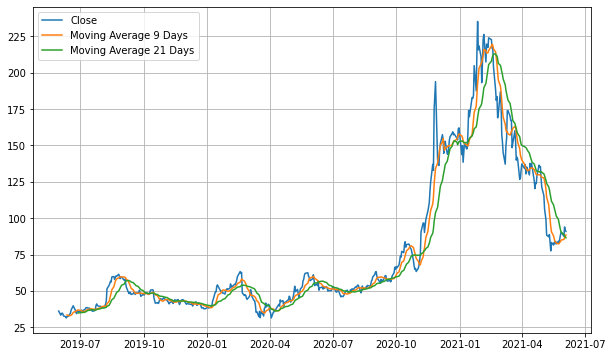

In [4]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(['Close'],label='Close')
plt.plot(appn['9-day'],label='Moving Average 9 Days')
plt.plot(appn['21-day'],label='Moving Average 21 Days')
plt.legend(loc=2)

## Zoom in the changing period

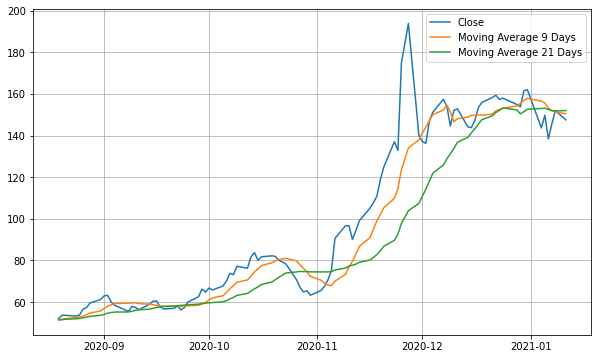

In [5]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(appn['Close'][-200:-100],label='Close')
plt.plot(appn['9-day'][-200:-100],label='Moving Average 9 Days')
plt.plot(appn['21-day'][-200:-100],label='Moving Average 21 Days')
plt.legend(loc=1)

In [6]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position'] = np.where(appn['9-day'] > appn['21-day'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position'] = np.where(appn['9-day'] < appn['21-day'],-1,appn['position'])

<AxesSubplot:xlabel='Date'>

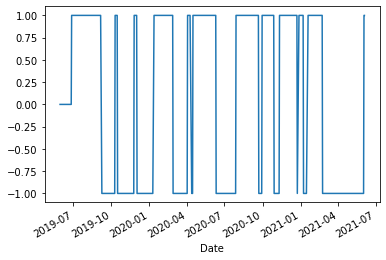

In [7]:
appn['position'].plot()

<AxesSubplot:xlabel='Date'>

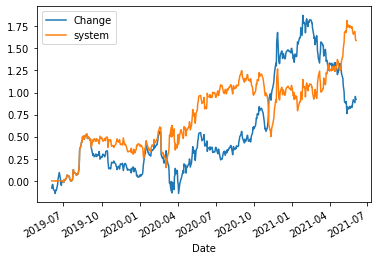

In [8]:
# Whether we are making money with this system
appn['system'] = appn['position'] * appn['Change']
appn[['Change','system']].cumsum().plot()

In [275]:
bit_depth = 16
appn_list = appn['Close'].tolist()
appn_9day_list = appn['9-day'].tolist()
appn_21day_list = appn['21-day'].tolist()
appn_list_bin = [ np.array(list(np.binary_repr(round(elem)).zfill(bit_depth))).astype(np.int8) for elem in appn_list ]
print(appn_list[0],appn_list_bin[0], len(appn_list_bin))

36.130001068115234 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0] 508


In [276]:
import math
import copy

class DGIM:
    buckets = []
    times = {}
    bits = [0]*bit_depth
    value = 0
    num_buckets = 0
    
    def __init__(self, num_buckets, snapshot):
        self.buckets = [0]*num_buckets
        self.num_buckets = num_buckets
        s = copy.deepcopy(snapshot)
        s.reverse()
        for b in s:
            self.add_bit(b)
    
    def calc_value(self):
        v = 0
        for i in range(self.num_buckets):
            if i == self.num_buckets-1 and self.buckets[i] > 0:
                v += pow(2,i)*self.buckets[i]
                v -= pow(2,i)/2
            elif (self.buckets[i] > 0):
                v += pow(2,i)*self.buckets[i]
                if (self.buckets[i+1] == 0):
                    v -= pow(2,i)/2
        self.value = math.ceil(v)
        
    def add_bit(self,bit):
        
        self.bits.insert(0,bit);
        self.bits = self.bits[0:-1]
        
        if bit == 1:
            self.buckets[0] += 1
        for i in range(self.num_buckets):
            if self.buckets[i] > 2:
                self.buckets[i] -= 2
                try:
                    self.buckets[i+1] += 1
                except:
                    pass
        if self.buckets[-1] > 2:
            self.buckets[-1] = 2
        
        self.calc_value()

In [294]:
class DGIMMovingAverage:
    
    streams = []
    mov_avg = []
    
    def __init__(self, window_size, quiet=True):
        for i in range(bit_depth):
            tmp = []
            for w in range(window_size):
                tmp.append(0)
            self.streams.append(tmp)

        for d in range(len(appn_list_bin)):
            day = appn_list_bin[d]
            counts = []
            for i in range(len(day)):
                self.streams[i].insert(0,day[i])
                self.streams[i] = self.streams[i][0:window_size]
                tmp = DGIM(5,self.streams[i])
                counts.insert(0,tmp.value)
            total = 0
            for i in range(len(counts)):
                total += counts[i]*pow(2,i)
            if not quiet:
                print(d, appn_21day_list[d], total/window_size, 100*(total/window_size-appn_21day_list[d])/appn_21day_list[d])
            self.mov_avg.append(total/window_size if d >= window_size else None)


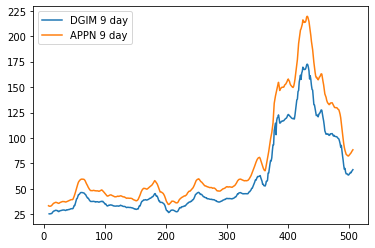

In [292]:
dgim_9day = DGIMMovingAverage(9)
plt.clf()
plt.plot(range(len(dgim_9day.mov_avg)), dgim_9day.mov_avg, label = "DGIM 9 day")
plt.plot(range(len(dgim_9day.mov_avg)), appn_9day_list, label = "APPN 9 day")
plt.legend()
plt.show()

0 nan 1.7142857142857142 nan
1 nan 3.2857142857142856 nan
2 nan 3.380952380952381 nan
3 nan 5.0476190476190474 nan
4 nan 6.571428571428571 nan
5 nan 8.095238095238095 nan
6 nan 8.095238095238095 nan
7 nan 9.571428571428571 nan
8 nan 11.095238095238095 nan
9 nan 12.666666666666666 nan
10 nan 14.19047619047619 nan
11 nan 15.857142857142858 nan
12 nan 17.38095238095238 nan
13 nan 19.19047619047619 nan
14 nan 20.952380952380953 nan
15 nan 19.80952380952381 nan
16 nan 21.571428571428573 nan
17 nan 23.238095238095237 nan
18 nan 24.857142857142858 nan
19 nan 26.38095238095238 nan
20 34.88428588140579 28.095238095238095 -19.461621800853397
21 34.855714343843005 28.095238095238095 -19.39560377938172
22 34.96190479823521 28.238095238095237 -19.231817027541858
23 35.072857084728426 28.38095238095238 -19.080010184542008
24 35.14999989100865 28.428571428571427 -19.122129397663407
25 35.29428554716564 28.666666666666668 -18.77816416383364
26 35.54428554716564 28.80952380952381 -18.947523164321623
27

151 39.87999961489723 32.38095238095238 -18.80403035697014
152 39.78571392240978 32.285714285714285 -18.850986691660278
153 39.74333299909319 32.23809523809524 -18.884268617252594
154 39.849047342936196 32.333333333333336 -18.86046094132066
155 39.99285688854399 32.523809523809526 -18.675953522275083
156 40.46047592163086 32.904761904761905 -18.67430830893796
157 40.88285700480143 33.333333333333336 -18.46623309760727
158 41.42238090151832 33.095238095238095 -20.103003799028365
159 41.98380951654343 33.666666666666664 -19.810357720395654
160 42.600952330089754 34.285714285714285 -19.518901784038945
161 43.0490475609189 35.142857142857146 -18.365540856330604
162 43.45714278448196 34.80952380952381 -19.899188996028784
163 43.782618931361604 35.142857142857146 -19.733314268041134
164 44.193571363176616 35.57142857142857 -19.50994799875411
165 44.651190439860024 36.04761904761905 -19.268403165709515
166 45.18690472557431 36.57142857142857 -19.066311814160755
167 45.80785715012323 37.190476

288 49.573809487479075 39.38095238095238 -20.560972037263184
289 49.45047614687965 39.095238095238095 -20.940623546038346
290 49.37333334059942 39.19047619047619 -20.624204324786646
291 49.39047622680664 39.23809523809524 -20.55534136194703
292 49.37095242454892 39.23809523809524 -20.523924876554084
293 49.43380955287388 39.285714285714285 -20.528653079640364
294 49.42380959647043 39.285714285714285 -20.512573582511028
295 49.33000001453218 39.0 -20.940604118161474
296 49.32809520903088 39.0 -20.937551237818795
297 49.48380951654343 39.142857142857146 -20.897648088773554
298 49.66523797171457 39.333333333333336 -20.803090975352774
299 49.76380938575382 39.42857142857143 -20.768582800940305
300 49.92714273361933 39.57142857142857 -20.741651925571844
301 49.96452367873419 39.61904761904762 -20.705643320462176
302 50.09452365693592 39.76190476190476 -20.626244429016623
303 50.31023806617374 40.0 -20.493319973188246
304 50.65023821876163 40.714285714285715 -19.61679323513129
305 50.9059524

426 192.58047775995163 156.0952380952381 -18.945450800154198
427 195.80285862513952 159.33333333333334 -18.62563475726691
428 199.21476309640067 162.71428571428572 -18.322174930606046
429 202.51523917061942 166.0 -18.03085995906475
430 205.5838107154483 162.95238095238096 -20.736764054867216
431 207.8990493047805 165.28571428571428 -20.497128371469834
432 210.13428751627603 167.52380952380952 -20.27773691581204
433 211.74095371791296 169.9047619047619 -19.75819560579026
434 212.76523917061942 170.95238095238096 -19.65210970609167
435 212.96000090099517 171.14285714285714 -19.63614931499684
436 211.82381039574034 170.0 -19.744621871168736
437 211.63904825846353 169.8095238095238 -19.76455894748476
438 209.46714346749442 166.0952380952381 -20.705827488876256
439 206.4509524390811 163.0952380952381 -21.00049131845796
440 205.0838092622303 161.71428571428572 -21.147219619121735
441 203.17333257765998 165.9047619047619 -18.343239341537462
442 200.615237281436 163.33333333333334 -18.58378478

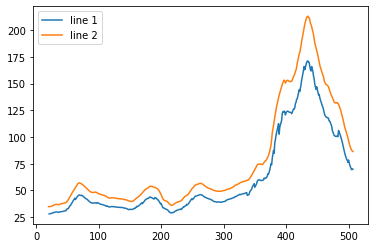

In [295]:
dgim_21day = DGIMMovingAverage(21,False)
plt.clf()
plt.plot(range(len(dgim_21day.mov_avg)), dgim_21day.mov_avg, label = "line 1")
plt.plot(range(len(dgim_21day.mov_avg)), appn_21day_list, label = "line 2")
plt.legend()
plt.show()